<a href="https://colab.research.google.com/github/YuriiKlim/AI/blob/Neural_lesson3/HW3ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [156]:
import torch
import pandas as pd
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'


device = "cuda" if torch.cuda.is_available() else "cpu"
#torch.set_default_device(device)

torch.manual_seed(0)

Дані про банани

In [157]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/banana_quality.csv')

df['Quality'] = df['Quality'].map({'Good': 1, 'Bad': 0})

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

In [158]:
df

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,0.380309,0.626747,0.680712,0.360975,0.567312,0.671933,0.543416,1
1,0.349951,0.628093,0.485275,0.293682,0.481689,0.646850,0.545720,1
2,0.478460,0.699448,0.572694,0.283811,0.499358,0.716580,0.617337,1
3,0.446465,0.705394,0.595677,0.374028,0.473461,0.633590,0.556625,1
4,0.541672,0.687704,0.458841,0.378242,0.442847,0.579430,0.705908,1
...,...,...,...,...,...,...,...,...
7995,0.099172,0.645045,0.541670,0.652073,0.567537,0.495237,0.679413,0
7996,0.554154,0.434381,0.259196,0.490009,0.450586,0.348024,0.661191,0
7997,0.589947,0.456598,0.279220,0.521305,0.505481,0.380883,0.570661,0
7998,0.367350,0.396800,0.388309,0.597746,0.488151,0.261917,0.553153,0


Потрібно на основі інформації про банан спрогнозувати його якість `Quality`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [159]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values)
      self.y = torch.FloatTensor(y.values)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['Quality'])
y = df['Quality']

dataset = MyDataset(X, y)

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=y)

dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

# Завдання 2
Створіть DataLoader

In [161]:
import torch
from torch.utils.data import DataLoader

batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = torch.Generator(device=device) if device == "cuda" else torch.Generator()

train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, generator=generator)
test_dl = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, generator=generator)

# Завдання 3
Створіть нейромережу

In [162]:
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import numpy as np

class Model(nn.Module):
    def __init__(self, input_size=2, hidden_sizes=[4], output_size=1, activation='sigmoid'):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

        activation_func = self.get_activation(activation)

        for i in range(len(hidden_sizes) - 1):
            self.layers.append(activation_func)
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))

        self.layers.append(activation_func)
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.output_activation = nn.Sigmoid()

    def get_activation(self, activation):
        if activation == 'sigmoid':
            return nn.Sigmoid()
        elif activation == 'relu':
            return nn.ReLU()
        elif activation == 'leaky_relu':
            return nn.LeakyReLU()
        elif activation == 'tanh':
            return nn.Tanh()
        else:
            raise ValueError("Unknown activation function")

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_activation(x)

    def predict(self, x, device='cpu'):
        if isinstance(x, pd.DataFrame):
            x = torch.tensor(x.values, dtype=torch.float32)
        elif isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
        x = x.to(device)
        self.to(device)
        self.eval()
        with torch.no_grad():
            y_pred = self.forward(x)
        return y_pred.cpu().numpy()

model = Model(input_size=7, hidden_sizes=[20, 15, 10, 5], output_size=1, activation='sigmoid')


In [163]:
from torchsummary import summary

summary(model, input_size=(7,))

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Linear: 2-1                       160
|    └─Sigmoid: 2-2                      --
|    └─Linear: 2-3                       315
|    └─Linear: 2-4                       160
|    └─Linear: 2-5                       55
|    └─Linear: 2-6                       6
├─Sigmoid: 1-2                           --
Total params: 696
Trainable params: 696
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Linear: 2-1                       160
|    └─Sigmoid: 2-2                      --
|    └─Linear: 2-3                       315
|    └─Linear: 2-4                       160
|    └─Linear: 2-5                       55
|    └─Linear: 2-6                       6
├─Sigmoid: 1-2                           --
Total params: 696
Trainable params: 696
Non-trainable params: 0

# Завдання 4
Визначте функцію втрат та оптимізатор

In [164]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.008)

# Завдання 5
Натренуйте нейромережу. Візміть невелику кількість епох

In [165]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression', log_interval=1):
    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}  # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    model.to(device)

    start_time_train = time.time()

    for epoch in range(epochs):
        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss'] + metrics_name}

        for batch in train_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary':
                        y_pred_ = y_pred.round()
                    elif task == 'multiclass':
                        y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x = batch[0].to(device)
                y = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_' + name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary':
                            y_pred_ = y_pred.round()
                        elif task == 'multiclass':
                            y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_' + name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS
        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = end_time_epoch - start_time_epoch

        if epoch + 1 == 1 or (epoch + 1) % log_interval == 0 or epoch + 1 == epochs:
            print(f'Epoch {epoch + 1:4d} {total_time_epoch:4.0f}sec', end='\t')
            for name in history_train:
                print(f'{name}: {history[name][-1]:10.3g}', end='\t')
                print(f"val_{name}: {history['val_' + name][-1]:10.3g}", end='\t')
            print()

    # END OF TRAINING LOOP
    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [166]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_dl, test_dl,
                epochs=100,
                metrics=[accuracy_score, roc_auc_score],
                device=device,
                task='binary',
                log_interval=10)

Epoch    1    1sec	loss:      0.694	val_loss:      0.692	accuracy_score:      0.506	val_accuracy_score:      0.501	roc_auc_score:      0.813	val_roc_auc_score:      0.919	
Epoch   10    1sec	loss:      0.294	val_loss:      0.303	accuracy_score:      0.878	val_accuracy_score:      0.869	roc_auc_score:      0.949	val_roc_auc_score:      0.945	
Epoch   20    1sec	loss:      0.292	val_loss:      0.298	accuracy_score:      0.876	val_accuracy_score:      0.877	roc_auc_score:      0.953	val_roc_auc_score:       0.95	
Epoch   30    1sec	loss:      0.269	val_loss:      0.304	accuracy_score:      0.883	val_accuracy_score:      0.868	roc_auc_score:      0.957	val_roc_auc_score:      0.953	
Epoch   40    1sec	loss:      0.249	val_loss:       0.26	accuracy_score:      0.892	val_accuracy_score:      0.887	roc_auc_score:      0.964	val_roc_auc_score:      0.965	
Epoch   50    1sec	loss:      0.234	val_loss:      0.235	accuracy_score:      0.901	val_accuracy_score:      0.902	roc_auc_score:      0.967

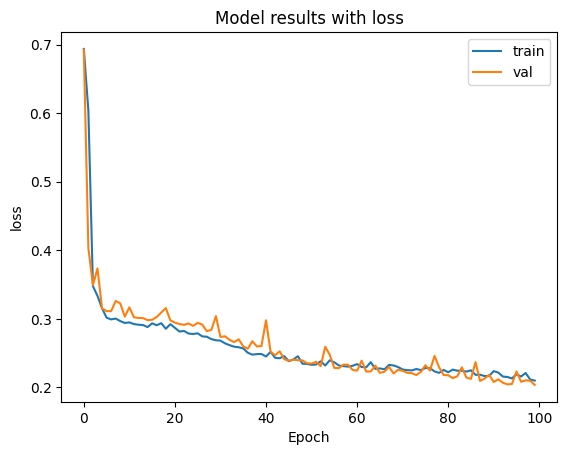

In [167]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_' + name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

plot_metric(history, 'loss')

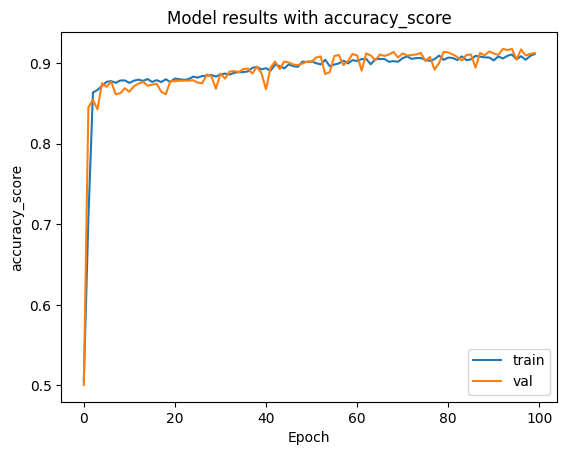

In [168]:
plot_metric(history, 'accuracy_score')

In [169]:
print(X_test)

          Size    Weight  Sweetness  Softness  HarvestTime  Ripeness   Acidity
4521  0.640787  0.661019   0.289875  0.706441     0.772894  0.496322  0.568264
5179  0.731932  0.551566   0.396122  0.622746     0.747596  0.575144  0.396509
7805  0.391539  0.422934   0.484307  0.515155     0.355879  0.592770  0.566104
3356  0.285113  0.576482   0.248229  0.343027     0.567906  0.558591  0.305671
3390  0.436560  0.428849   0.328526  0.365394     0.422345  0.657472  0.420468
...        ...       ...        ...       ...          ...       ...       ...
4197  0.577112  0.351875   0.468190  0.480501     0.863271  0.631720  0.481836
6746  0.485496  0.242423   0.268793  0.535827     0.278979  0.453500  0.470597
510   0.493937  0.503982   0.544396  0.282634     0.399745  0.741070  0.735301
6939  0.428285  0.444352   0.471615  0.522055     0.503189  0.468704  0.606567
7642  0.281145  0.654773   0.357430  0.552547     0.560910  0.472904  0.811293

[1600 rows x 7 columns]


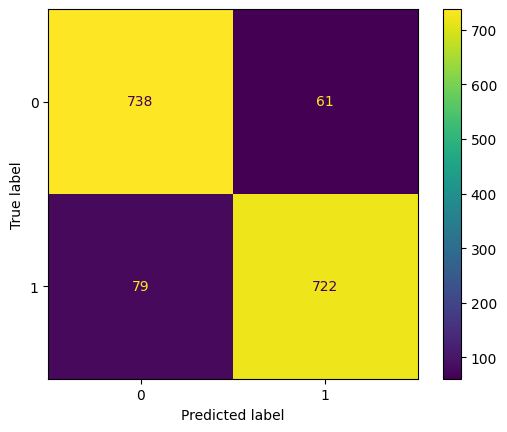

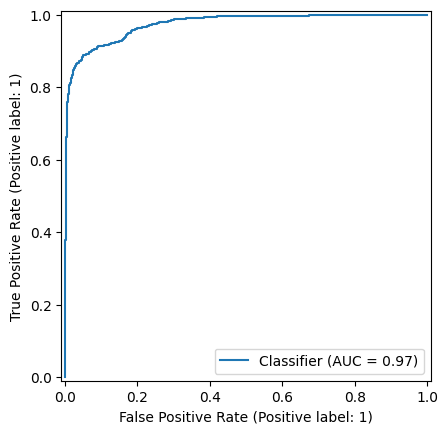

In [170]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

model = model.to('cpu')
y_pred = model.predict(X_test, device='cpu')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round())
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [171]:
torch.save(model.state_dict(), 'model.pth')

In [172]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>